### What drives the demand for an appointment?

![planner](./images/planner.png)

#### Overview

&nbsp;&nbsp;&nbsp;&nbsp;Scheduling is a complex problem. Identifying the optimal schedule based on past history of customer preferences, available appointments, staff availability, equipment availability, etc., is challenging. By understanding the factors that drive up demand for appointments, business owners can better focus on filling up low demand slots first, than higher demand slots, optimizing for revenue and productivity. This is especially useful when a customer arrives to book an appointment either online or through a phone call.
   
Businesses that could benefit from this project are Salons, Spas, Gyms, Personal Trainer, Dentists etc.,

In this project we are a analyzing existing data for a fictional business call 'Relax Spa' and build models that could label upcoming appointments as **LOW DEMAND** or **HIGH DEMAND**. We will use the industry standard approach [CRISP-DM](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip)  

#### Business Understanding

'Relax Spa' is interested in understanding which appointments are in high demand and which ones are in low demand. When a customer is looking to book appointments, it would be in the best interest of 'Relax Spa' to fill up low demand appointments first, this way keep the high demand ones for walkins or last minute reservations

To accomplish this goal, we need to perform the below data tasks

* Understand what features we have available in the given dataset.
* Which among these features is relevant and strongly influences the outcome (demand).
* Build a model to predict the appropriate demand for an upcoming appointment.

#### Data Understanding

##### Imports

In [303]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [304]:
df = pd.read_csv('./data/reservations-1.csv')

In [305]:
df.shape

(52480, 8)

In [306]:
df.head()

,customer_name,scheduled_date,scheduled_day_of_week,service_type,service_provider,booking_date,status,channel
0,Wendy Wall,2018-09-27 18:00:00,Thursday,STRETCH,Cindy,2018-09-04 08:07:57,rescheduled,phone
1,Joel Harrington,2018-07-13 12:00:00,Friday,DEEP_TISSUE,Cindy,2018-06-15 19:19:12,show,store
2,Amy Frank,2019-04-13 12:00:00,Saturday,SWEDISH,Cindy,2019-02-28 20:49:26,noshow,online
3,Justin Snyder,2019-08-24 18:00:00,Saturday,SPORTS,Delores,2019-07-11 13:41:51,show,phone
4,Brian Stark,2018-04-03 18:00:00,Tuesday,DEEP_TISSUE,Delores,2018-02-07 00:51:55,noshow,online


In [307]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52480 entries, 0 to 52479
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   customer_name          52480 non-null  object
 1   scheduled_date         52480 non-null  object
 2   scheduled_day_of_week  52480 non-null  object
 3   service_type           52480 non-null  object
 4   service_provider       52480 non-null  object
 5   booking_date           52480 non-null  object
 6   status                 52480 non-null  object
 7   channel                52480 non-null  object
dtypes: object(8)
memory usage: 3.2+ MB


There are no numeric columns, so we will go straight to exploring categorical features

_Explore Categorical Features_

In [308]:
# Let's discover the unique counts on the object columns
unique_counts_df = pd.DataFrame(columns=['feature', 'unique_count'])

for column in df.select_dtypes(include='object').columns:
    unique_counts_df.loc[len(unique_counts_df.index)] = [column, df[column].nunique()] 
    
unique_counts_df

,feature,unique_count
0,customer_name,42062
1,scheduled_date,8326
2,scheduled_day_of_week,7
3,service_type,7
4,service_provider,8
5,booking_date,52465
6,status,4
7,channel,3


In [309]:
df['schedule'] = pd.to_datetime(df.scheduled_date,format='%Y-%m-%d %H:%M:%S')
df.drop(['scheduled_date'],inplace=True,axis=1)
df['booking_date'] = pd.to_datetime(df.booking_date,format='%Y-%m-%d %H:%M:%S')

In [310]:
df['scheduled_hour'] = df['schedule'].dt.strftime('%H')
df['scheduled_date'] =  pd.to_datetime(df['schedule'].dt.strftime('%Y-%m-%d'),format='%Y-%m-%d')
df['scheduled_day'] =  df['schedule'].dt.strftime('%d')
df['scheduled_month'] =  df['schedule'].dt.strftime('%m')
df['scheduled_year'] =  df['schedule'].dt.strftime('%Y')
df['appointment_count'] = 1

**scheduled_date**, **scheduled_time** and **service_provider** together form a unique key

In [311]:
df = df.set_index(['schedule']).sort_index()

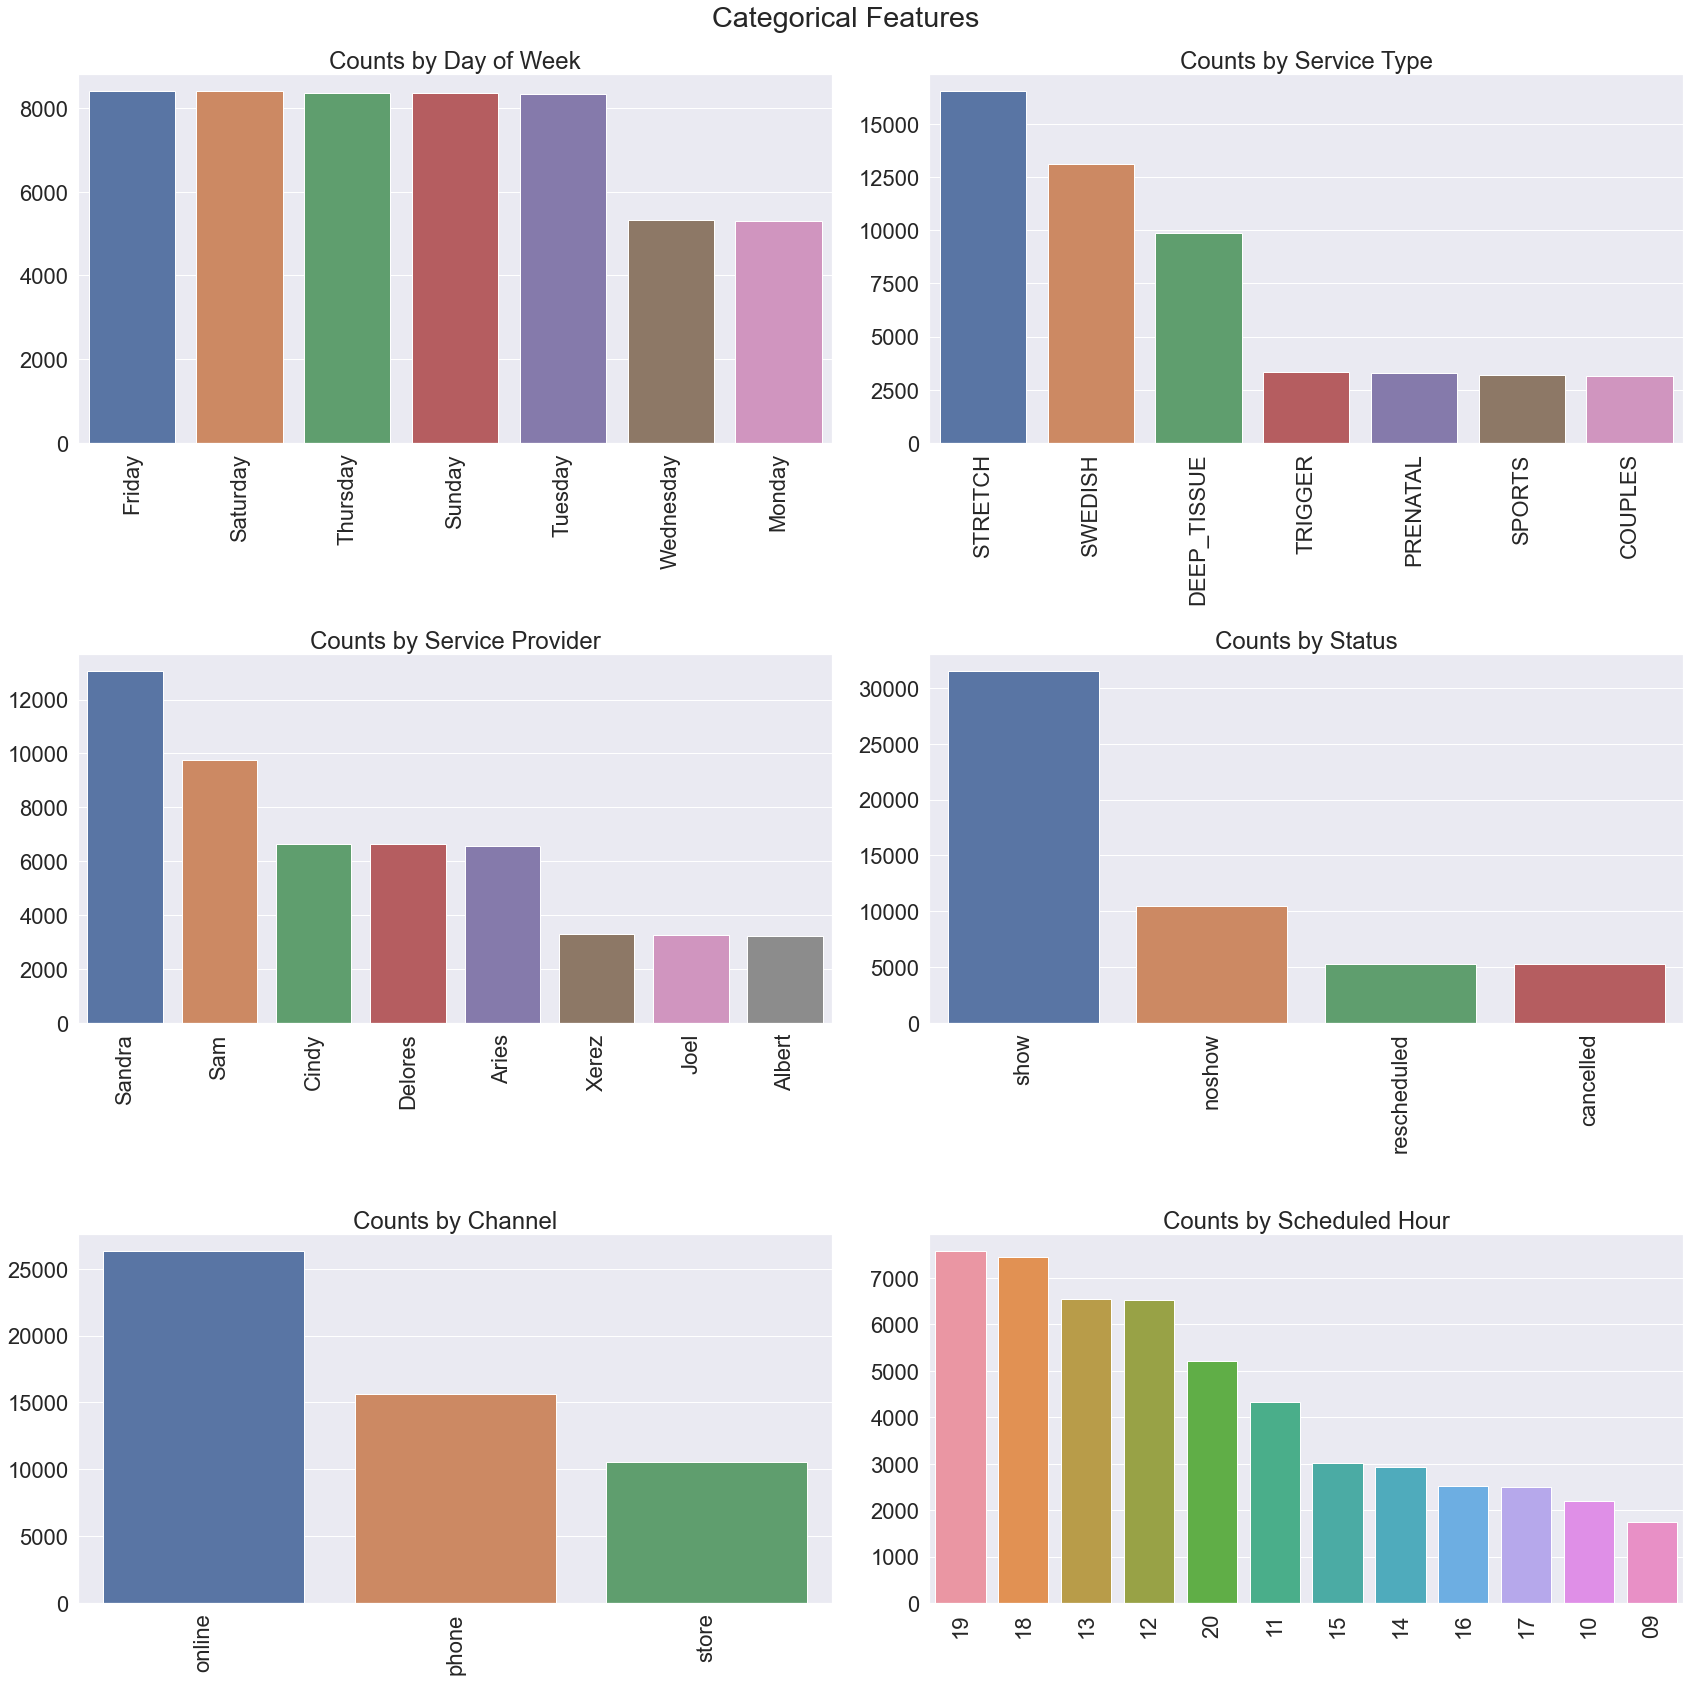

In [753]:
sns.set(font_scale = 2)

fig, ax = plt.subplots(3, 2, figsize=(24,24))
fig.suptitle('Categorical Features')
fig.subplots_adjust(hspace=0.625, wspace=0.225)

def add_subplot(feature, plot_x, plot_y, title):
    plot = sns.countplot(x=feature, data=df, ax=ax[plot_x, plot_y], order = df[feature].value_counts().index);
    plot.set_title(title)
    plot.set_xticklabels(plot.get_xticklabels(),rotation = 90)
    plot.set(xlabel=None, ylabel=None)
    
add_subplot('scheduled_day_of_week',0,0,"Counts by Day of Week")
add_subplot('service_type',0,1,"Counts by Service Type")
add_subplot('service_provider',1,0,"Counts by Service Provider")
add_subplot('status',1,1,"Counts by Status")
add_subplot('channel',2,0,"Counts by Channel")
add_subplot('scheduled_hour',2,1,"Counts by Scheduled Hour")
fig.tight_layout()

Let us observe weekly appointment reservation trends

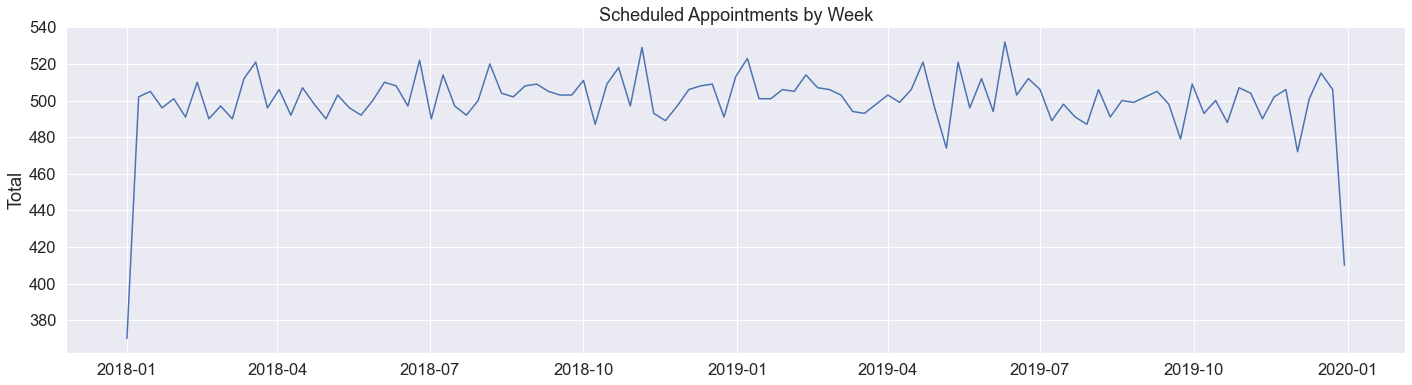

In [313]:
sns.set(font_scale = 1.5)

appointments = pd.DataFrame(df.resample('7D', on='scheduled_date').sum()['appointment_count'])
appointments.sort_index(inplace = True)

appointments.head()

fig, ax = plt.subplots(1, 1, figsize=(24,6))
plot = sns.lineplot(data = appointments, x='scheduled_date', y='appointment_count', ax=ax)
plot.set_title('Scheduled Appointments by Week')
plot.set(xlabel=None, ylabel="Total")
plt.show()

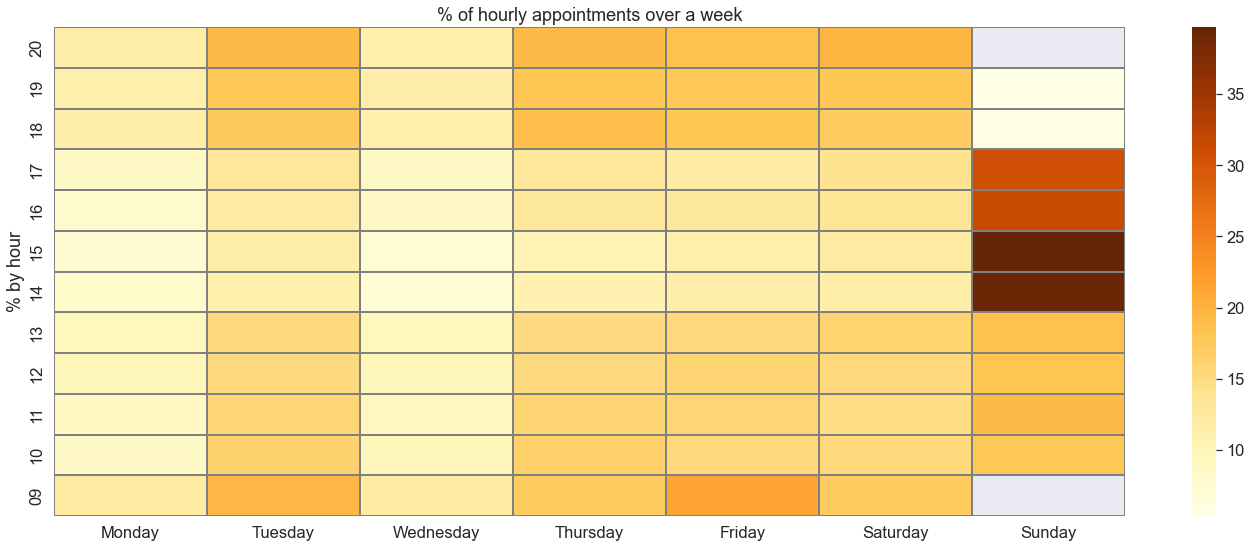

In [394]:
dow_appointments = df.groupby(['scheduled_hour','scheduled_day_of_week']).sum()['appointment_count'].groupby(level=0).apply(
    lambda x: 100* x/ x.sum()).unstack().loc[:,['Monday','Tuesday','Wednesday',
                                                'Thursday','Friday','Saturday',
                                                'Sunday']]
fig, ax = plt.subplots(1, 1, figsize=(24,9))
plot = sns.heatmap(dow_appointments, cmap='YlOrBr', linewidths=0.01, linecolor='gray')
plot.invert_yaxis()
plot.set_title('% of hourly appointments over a week')
plot.set(xlabel=None, ylabel="% by hour")
plt.show()

By observation, there is no direct feature to evaluate and label a particular time slot to be of **low demand** or **high demand**. We would have to engineer a feature to estimate demand and use that for our model

#### Data Preparation

To quantify the demand of a particular timeslot on a given day, let us introduce a feature  **S/D ratio (s_d_ratio)**. The supply per hour is 8 (8 available service providers) and the number of reservations count as demand on that particular date on that particular hour. 

In [352]:
df_ratio = df.drop(['customer_name', 'service_type', 'service_provider', 'booking_date', 'channel'], axis=1)

In [353]:
df_ratio.head()

,scheduled_day_of_week,status,scheduled_hour,scheduled_date,scheduled_day,scheduled_month,scheduled_year,appointment_count
schedule,,,,,,,,
2018-01-01 10:00:00,Monday,show,10,2018-01-01,01,01,2018,1
2018-01-01 11:00:00,Monday,cancelled,11,2018-01-01,01,01,2018,1
2018-01-01 11:00:00,Monday,show,11,2018-01-01,01,01,2018,1
2018-01-01 16:00:00,Monday,show,16,2018-01-01,01,01,2018,1
2018-01-01 18:00:00,Monday,show,18,2018-01-01,01,01,2018,1


In [396]:
df_ratio_grouped = df_ratio.groupby(['schedule']).sum()
df_ratio_grouped['s_d_ratio'] = 8 / df_ratio_grouped['appointment_count']

df_ratio_grouped_temp = df_ratio.groupby(['schedule']).first()
df_ratio_grouped_temp.drop(['appointment_count', 'status', 'scheduled_date', 'scheduled_year'], inplace=True, axis=1)
df_ratio_clean = df_ratio_grouped.join(df_ratio_grouped_temp)
df_ratio_clean

,appointment_count,s_d_ratio,scheduled_day_of_week,scheduled_hour,scheduled_day,scheduled_month
schedule,,,,,,
2018-01-01 10:00:00,1,8.0,Monday,10,01,01
2018-01-01 11:00:00,2,4.0,Monday,11,01,01
2018-01-01 16:00:00,1,8.0,Monday,16,01,01
2018-01-01 18:00:00,1,8.0,Monday,18,01,01
2018-01-01 19:00:00,2,4.0,Monday,19,01,01
...,...,...,...,...,...,...
2020-01-05 15:00:00,2,4.0,Sunday,15,05,01
2020-01-05 16:00:00,5,1.6,Sunday,16,05,01
2020-01-05 17:00:00,2,4.0,Sunday,17,05,01


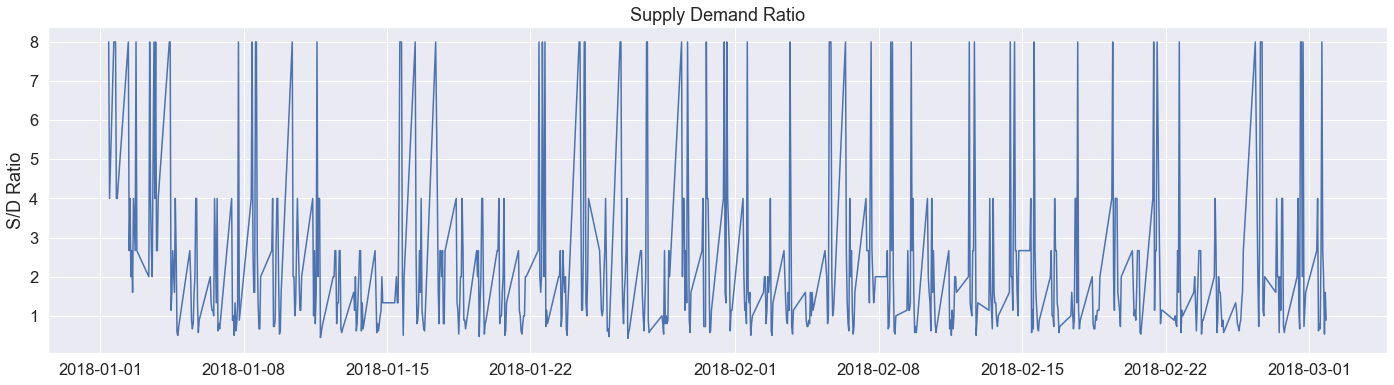

In [397]:
sns.set(font_scale = 1.5)

fig, ax = plt.subplots(1, 1, figsize=(24,6))
plot = sns.lineplot(data = df_ratio_clean.loc['2018-01-01':'2018-03-01'], 
                                            x='schedule', y='s_d_ratio', ax=ax)
plot.set_title('Supply Demand Ratio')
plot.set(xlabel=None, ylabel="S/D Ratio")
plt.show()

#### Modeling

**Question**: Can we use timeseries forecasting methods to model Supply / Demand Ratio? Does the data show the signs of supporting this?

In [398]:
training_set = df_ratio_clean[:'2018-03-15']
validation_set = df_ratio_clean['2018-03-16':'2018-03-31']

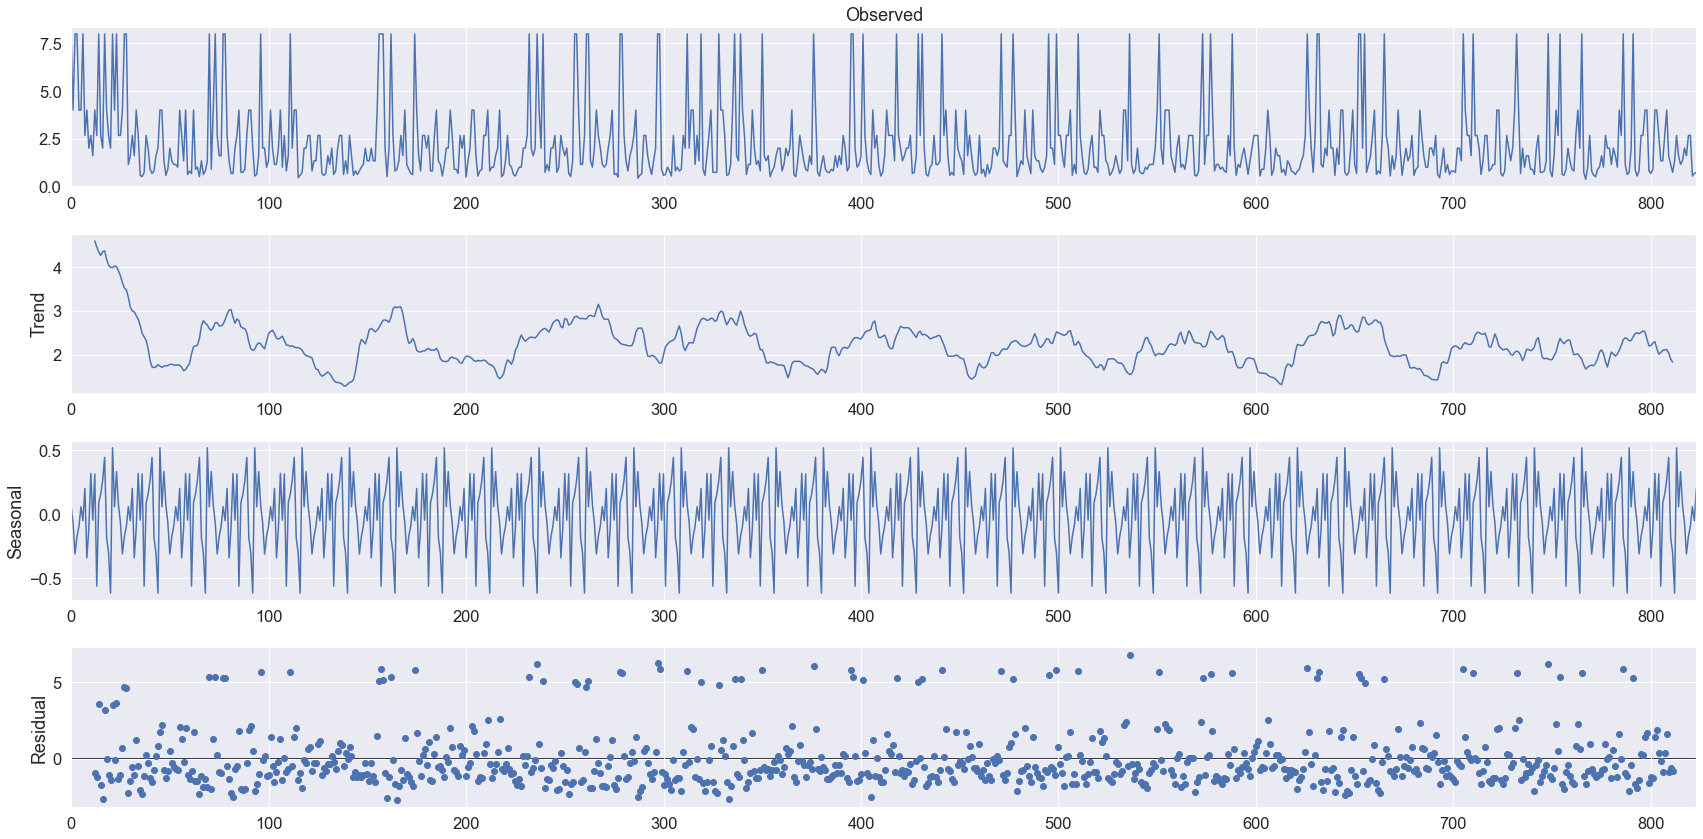

In [399]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(pd.DataFrame(training_set['s_d_ratio']).s_d_ratio.values, period=24)
fig = decompose.plot()
fig.set_size_inches((24, 12))
fig.tight_layout()
plt.show()

The trend seems repitive, and there is a clear seasonal component along with lot of residue. Lets inspect **ACF** and **PACF** plots to see if we can apply any of the AR, MA, their combination ARMA or similar models for analysis.

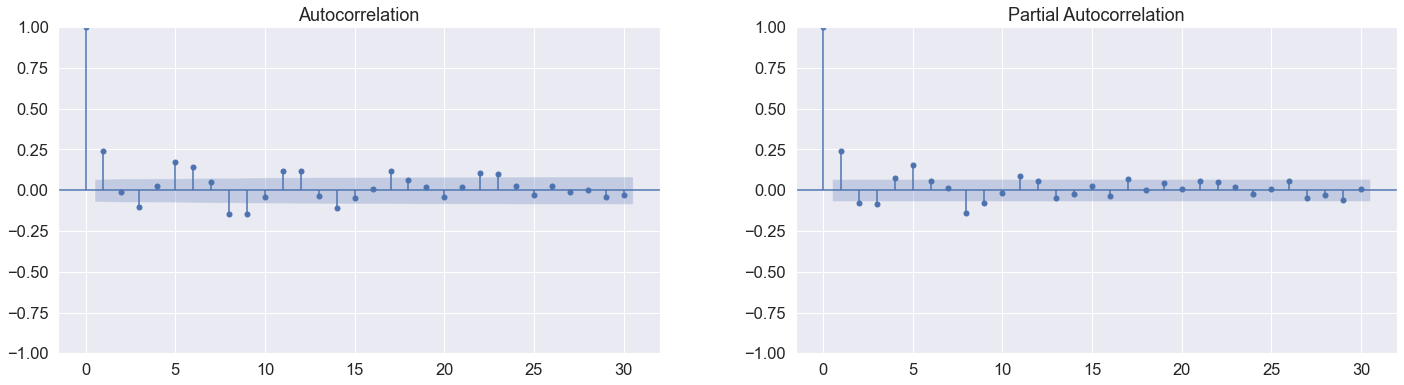

In [400]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
sns.set(font_scale = 1.5)

fig, ax = plt.subplots(1, 2, figsize=(24,6))
fig.subplots_adjust(hspace=0.625, wspace=0.225)

plot_acf(training_set['s_d_ratio'],title="Autocorrelation", ax=ax[0]) 
plot_pacf(training_set['s_d_ratio'],title="Partial Autocorrelation", ax=ax[1]) 
plt.show()

**Question**: Can we use timeseries forecasting methods to model Supply / Demand Ratio? Does the data show the signs of supporting this?

From the above **ACF** and **PACF** plots, its clear that since both ACF and PACF drop instantly (no significant lags), it is likely that we won't be able to model the time series. We will have to use other modeling techniques. Please refer to [this article](https://towardsdatascience.com/time-series-from-scratch-autocorrelation-and-partial-autocorrelation-explained-1dd641e3076f) for more information time series forecasting

<hr/>

Let us explore numeric features for the `df_ratio_clean` dataframe

In [442]:
def demand_classification(s_d_ratio):
    if s_d_ratio < 2.0:
        return 1
    else:
        return 0

df_ratio_clean['demand'] = df_ratio_clean['s_d_ratio'].apply(demand_classification)

df_clean = df_ratio_clean.drop(['s_d_ratio', 'appointment_count'], axis=1)
df_clean.head()

df_ratio_clean.loc[df_ratio_clean['demand'] == 1].head()

,appointment_count,s_d_ratio,scheduled_day_of_week,scheduled_hour,scheduled_day,scheduled_month,demand
schedule,,,,,,,
2018-01-02 14:00:00,5,1.600000,Tuesday,14,02,01,1
2018-01-04 11:00:00,7,1.142857,Thursday,11,04,01,1
2018-01-04 12:00:00,5,1.600000,Thursday,12,04,01,1
2018-01-04 15:00:00,5,1.600000,Thursday,15,04,01,1
2018-01-04 18:00:00,14,0.571429,Thursday,18,04,01,1


In [443]:
df_clean.shape

(8326, 5)

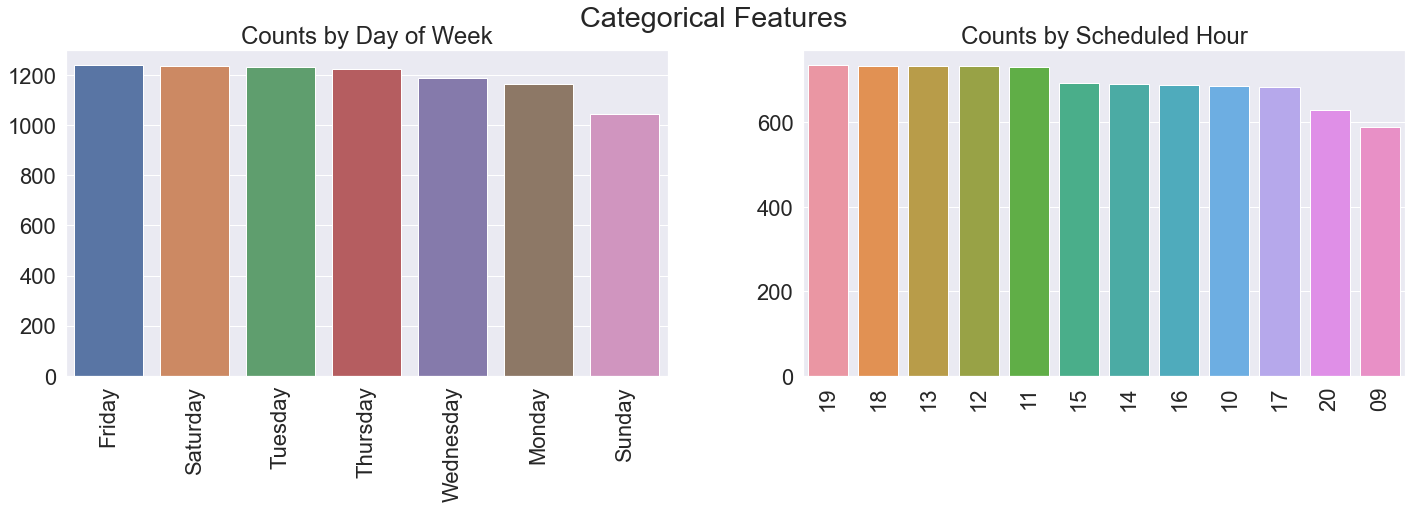

In [444]:
sns.set(font_scale = 2)

fig, ax = plt.subplots(1, 2, figsize=(24,6))
fig.suptitle('Categorical Features')
fig.subplots_adjust(hspace=0.625, wspace=0.225)

def add_subplot(feature, plot_x, plot_y, title):
    plot = sns.countplot(x=feature, data=df_clean, ax=ax[plot_y], order = df_clean[feature].value_counts().index);
    plot.set_title(title)
    plot.set_xticklabels(plot.get_xticklabels(),rotation = 90)
    plot.set(xlabel=None, ylabel=None)
    
add_subplot('scheduled_day_of_week',0,0,"Counts by Day of Week")
add_subplot('scheduled_hour',0,1,"Counts by Scheduled Hour")

_Test Train Split_

In [445]:
from sklearn.model_selection import train_test_split

X = df_clean.drop(columns=['demand'])
y = df_clean['demand']
X_train, X_test, y_train, y_test = train_test_split(X, y)

print(f'{df_clean.shape}')
print(f'{X_train.shape},{X_test.shape}')
print(f'{y_train.shape},{y_test.shape}')

(8326, 5)
(6244, 4),(2082, 4)
(6244,),(2082,)


_Utility Functions_

In [446]:
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from category_encoders import TargetEncoder
from sklearn.metrics import ConfusionMatrixDisplay,classification_report, accuracy_score
from sklearn.linear_model import LinearRegression, LogisticRegression
import time
import warnings
warnings.filterwarnings('ignore')

numeric_columns = list(X_train.select_dtypes(include='number').columns)
numeric_columns_transformer = Pipeline(
    steps = [
        ('scaler', MinMaxScaler())
    ]
)

object_columns = list(X_train.select_dtypes(include='object').columns)
object_columns_transformer = Pipeline(
    steps = [
        ('encoder', TargetEncoder(handle_unknown='return_nan', handle_missing='return_nan')),
        ('imputer', IterativeImputer(n_nearest_features=3, sample_posterior=True))
    ]
)

preprocessor = ColumnTransformer(
    transformers = [
        ('numeric',numeric_columns_transformer,numeric_columns),
        ('object',object_columns_transformer,object_columns)
    ]
)

In [451]:
def to_binary(series):
    series[series <= 0.5] = 0
    series[series > 0.5] = 1
    return series

def build_and_score_model(pipeline, title):
    start = time.time()
    pipeline.fit(X_train, y_train)
    stop = time.time()

    y_pred_train = pipeline.predict(X_train)
    y_pred_train = to_binary(y_pred_train)

    y_pred = pipeline.predict(X_test)
    y_pred = to_binary(y_pred)

    print('Train Accuracy Score: %0.5f' % accuracy_score(y_train, y_pred_train))
    print('Test Accuracy Score: %0.5f' % accuracy_score(y_test, y_pred))
    print('Fit Time: %0.5fs' % (stop-start))
    sns.set(font_scale = 1.2)

    # plot the confusion matrix 
    fig, ax = plt.subplots(2, 2,figsize=(18, 12))
    fig.suptitle(title, size=16)

    ax[0][0].set_title("Test Data", size=12)
    ax[0][0].grid(False)
    ConfusionMatrixDisplay.from_predictions(y_true=y_test,y_pred=y_pred,ax=ax[0][0])

    ax[0][1].set_title("Training Data", size=12)
    ax[0][1].grid(False)
    ConfusionMatrixDisplay.from_predictions(y_true=y_train,y_pred=y_pred_train,ax=ax[0][1])
    
    ax[1][0].grid(False)
    sns.heatmap(pd.DataFrame(classification_report(y_test, y_pred,output_dict=True)).iloc[:-1, :].T, 
                cmap='Pastel1', annot=True, ax=ax[1][0])
    
    ax[1][1].grid(False)
    sns.heatmap(pd.DataFrame(classification_report(y_train, y_pred_train,output_dict=True)).iloc[:-1, :].T, 
                cmap='Pastel1', annot=True, ax=ax[1][1])
    plt.show()
    
    fig.tight_layout()

_Baseline Model_

Train Accuracy Score: 0.82799
Test Accuracy Score: 0.82901
Fit Time: 0.15699s


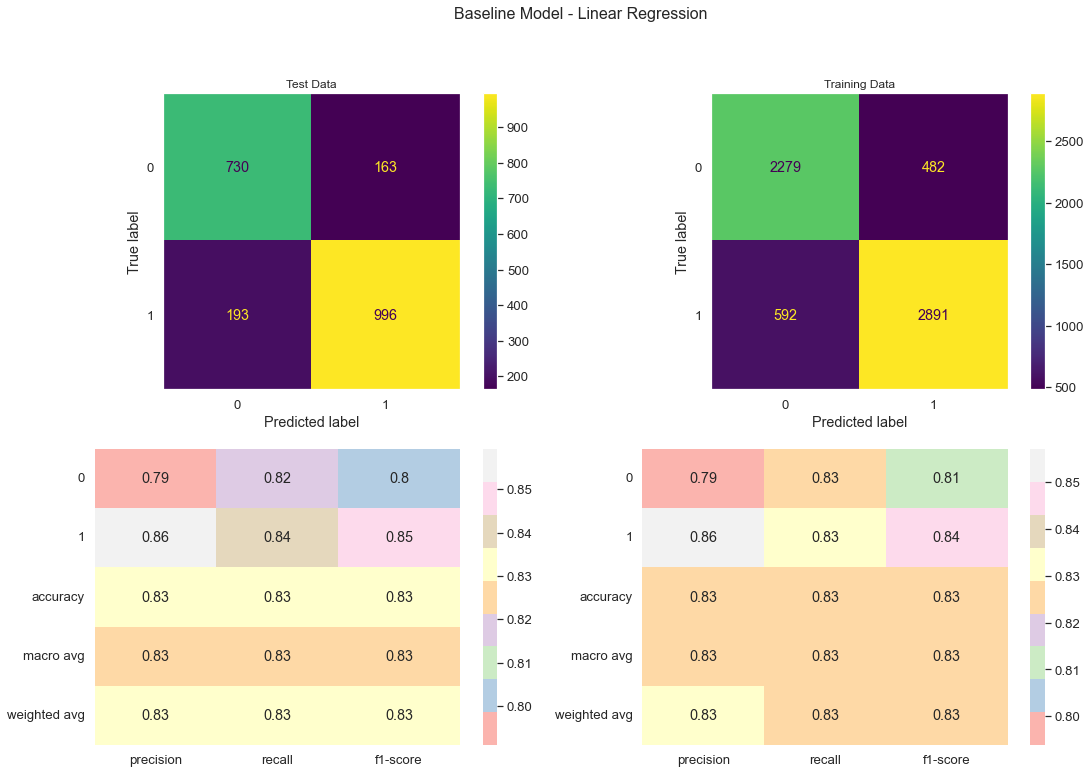

In [452]:
pipeline = Pipeline([('preprocessor',preprocessor),('model',LinearRegression())])
build_and_score_model(pipeline,"Baseline Model - Linear Regression")

_Simple Model_

Train Accuracy Score: 0.84225
Test Accuracy Score: 0.84342
Fit Time: 0.16564s


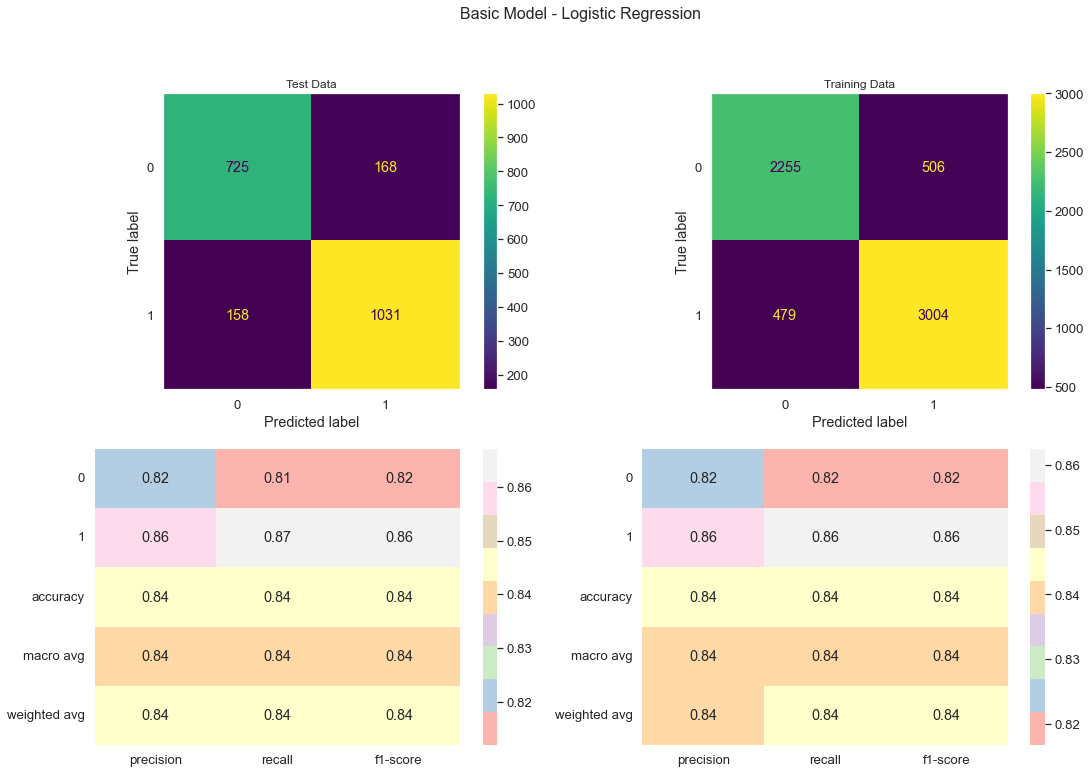

In [454]:
pipeline = Pipeline([('preprocessor',preprocessor),('model',LogisticRegression())])
build_and_score_model(pipeline,"Basic Model - Logistic Regression")

_K Nearest Neighbors_

Train Accuracy Score: 0.86931
Test Accuracy Score: 0.83045
Fit Time: 0.16078s


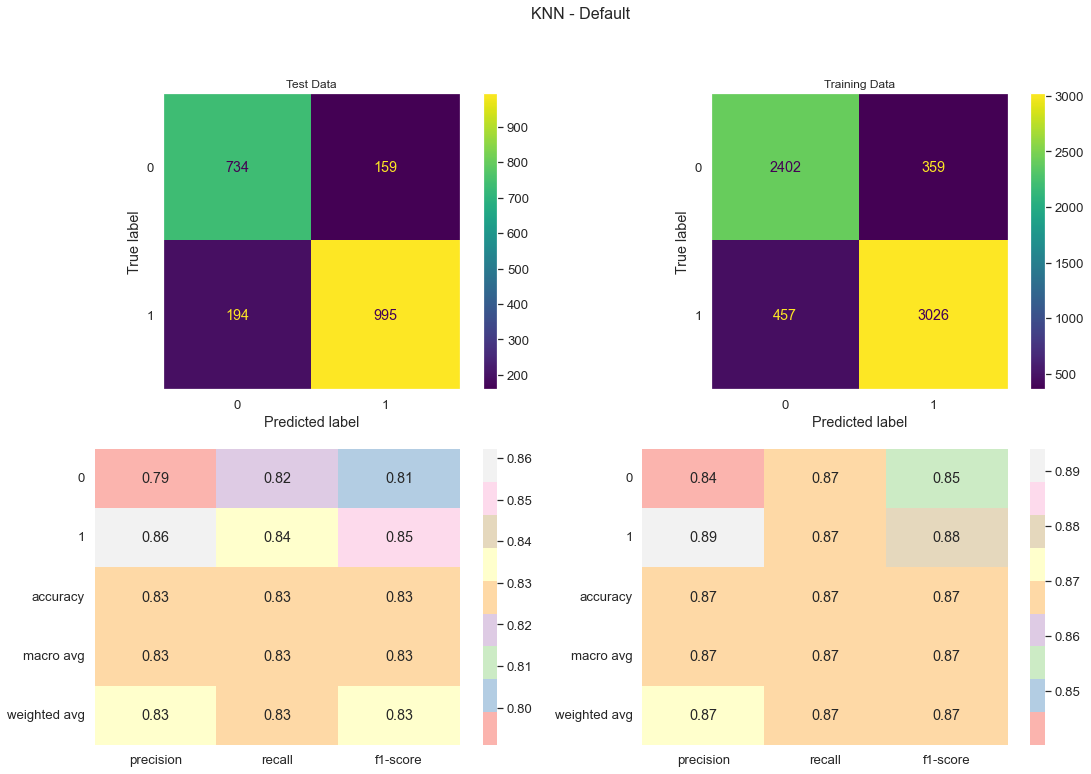

In [455]:
from sklearn.neighbors import KNeighborsClassifier

pipeline = Pipeline([('preprocessor',preprocessor),('model',KNeighborsClassifier())])
build_and_score_model(pipeline,"KNN - Default")

_Decision Tree Classifier_

Train Accuracy Score: 0.99968
Test Accuracy Score: 0.76945
Fit Time: 0.12866s


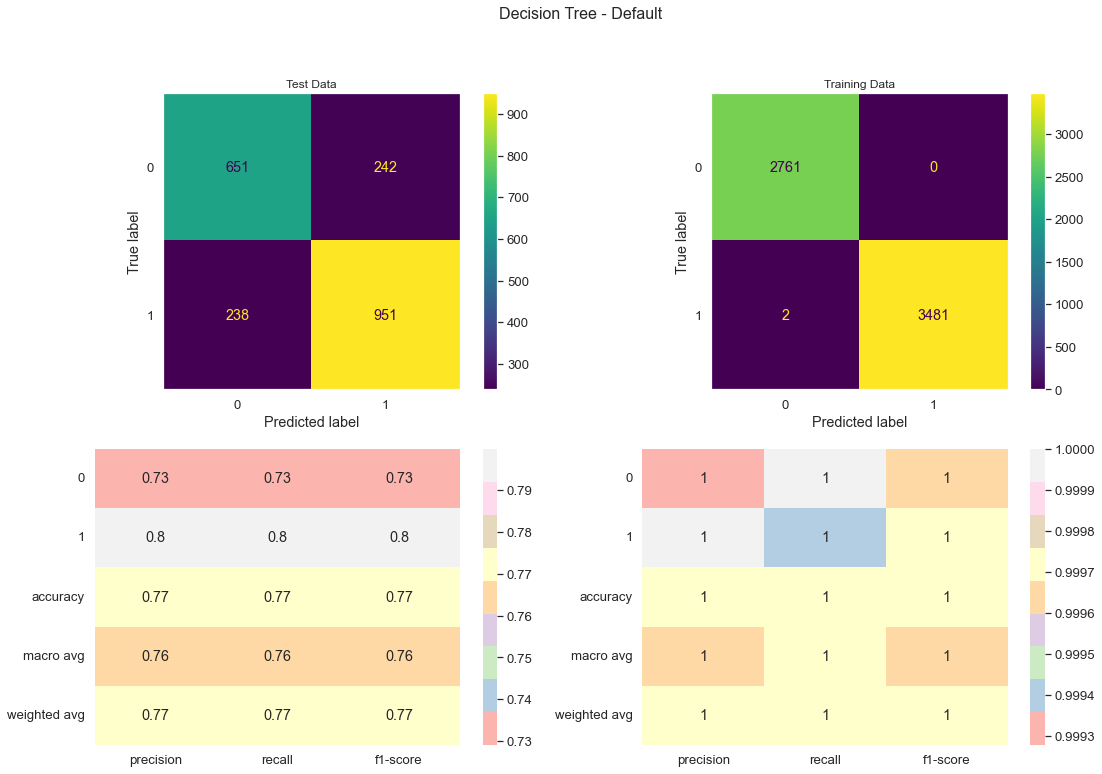

In [457]:
from sklearn.tree import DecisionTreeClassifier

pipeline = Pipeline([('preprocessor',preprocessor),('model',DecisionTreeClassifier())])
build_and_score_model(pipeline,"Decision Tree - Default")

_Support Vector Machines (SVM)_

Train Accuracy Score: 0.84385
Test Accuracy Score: 0.84390
Fit Time: 0.92535s


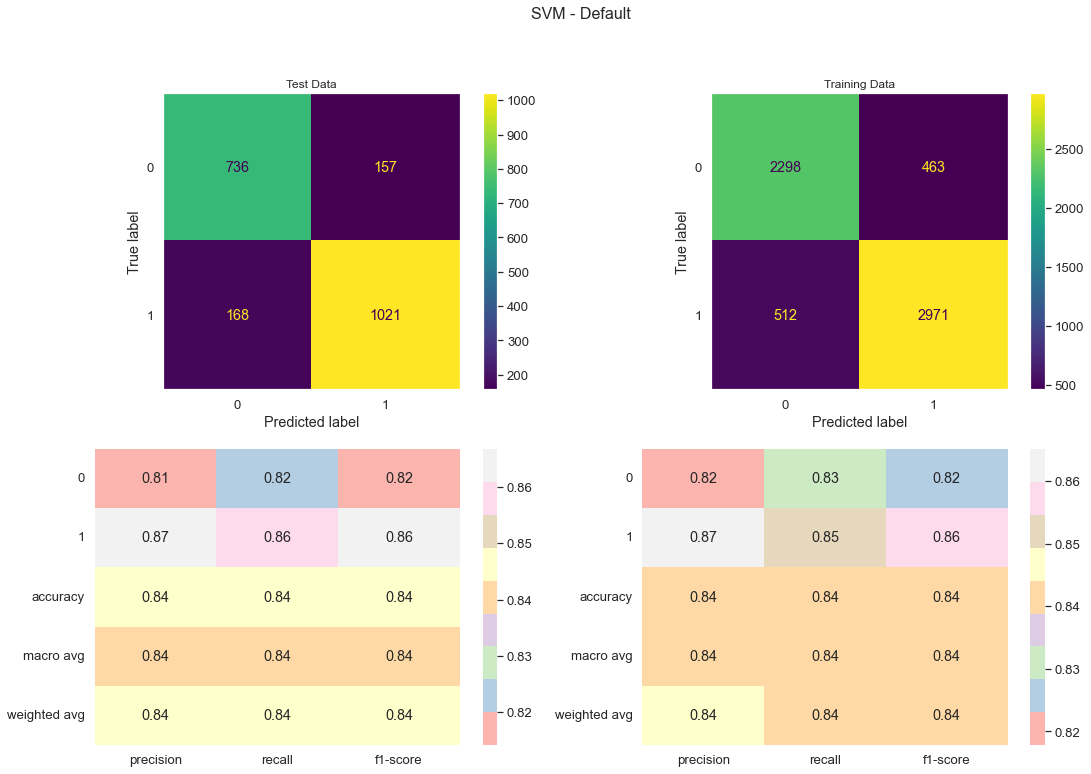

In [458]:
from sklearn.svm import SVC

pipeline = Pipeline([('preprocessor',preprocessor),('model',SVC())])
build_and_score_model(pipeline,"SVM - Default")

_Random Forest Classifier_

Train Accuracy Score: 0.99968
Test Accuracy Score: 0.82853
Fit Time: 0.51333s


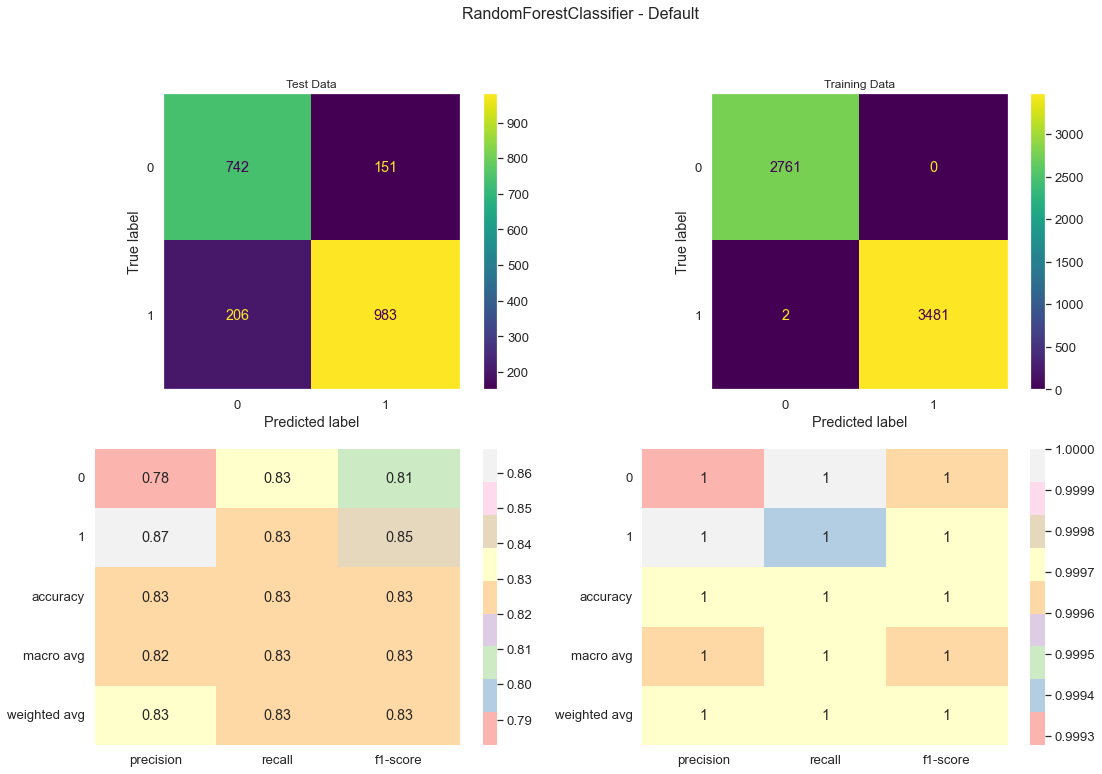

In [467]:
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([('preprocessor',preprocessor),('model',RandomForestClassifier())])
build_and_score_model(pipeline,"RandomForestClassifier - Default")

In [460]:
df_basic_results = pd.DataFrame({'Model':['Logistic Regression','KNN','Decision Tree','SVM', 'Random Forest Classifier'],                                
                                'Train Time':['0.16564s','0.16078s','0.12866s','0.92535s', '0.51333s'],
                                'Train Accuracy':[0.82799,0.86931,0.99968,0.84385,0.99968],
                                'Test Accuracy': [0.82901,0.83045,0.76945,0.84390,0.82853]})
df_basic_results.set_index('Model', inplace=True)
                                
df_basic_results

,Train Time,Train Accuracy,Test Accuracy
Model,,,
Logistic Regression,0.16564s,0.82799,0.82901
KNN,0.16078s,0.86931,0.83045
Decision Tree,0.12866s,0.99968,0.76945
SVM,0.92535s,0.84385,0.84390


_Grid Search Hyperparameters_

In [462]:
from sklearn.model_selection import GridSearchCV

def grid_search_hyperparams(title, pipeline, params):
    print(f'{"-"*30} {title} {"-"*30}')
    grid = GridSearchCV(pipeline, param_grid=params)
    
    start = time.time()
    grid.fit(X_train, y_train)
    stop = time.time()
    
    y_pred_train = grid.best_estimator_.predict(X_train)
    y_pred = grid.best_estimator_.predict(X_test)
    
    print('Train Accuracy Score: %0.5f' % accuracy_score(y_train, y_pred_train))
    print('Test Accuracy Score: %0.5f' % accuracy_score(y_test, y_pred))
    print('Grid Search Time: %0.5fs' % (stop-start))
    print(f'Best Params: {grid.best_params_}')
    sns.set(font_scale = 1.2)
    
    # plot the confusion matrix 
    fig, ax = plt.subplots(2, 2,figsize=(18, 12))
    fig.suptitle(title, size=16)

    ax[0][0].set_title("Test Data", size=12)
    ax[0][0].grid(False)
    ConfusionMatrixDisplay.from_predictions(y_true=y_test,y_pred=y_pred,ax=ax[0][0])

    ax[0][1].set_title("Training Data", size=12)
    ax[0][1].grid(False)
    ConfusionMatrixDisplay.from_predictions(y_true=y_train,y_pred=y_pred_train,ax=ax[0][1])
    
    ax[1][0].grid(False)
    sns.heatmap(pd.DataFrame(classification_report(y_test, y_pred,output_dict=True)).iloc[:-1, :].T, 
                cmap='Pastel1', annot=True, ax=ax[1][0])
    
    ax[1][1].grid(False)
    sns.heatmap(pd.DataFrame(classification_report(y_train, y_pred_train,output_dict=True)).iloc[:-1, :].T, 
                cmap='Pastel1', annot=True, ax=ax[1][1])
    plt.show()
    
    plt.show()
    fig.tight_layout()

_Logistic Regression (Grid Search CV)_

------------------------------ Logistic Regression - Grid Search CV ------------------------------
Train Accuracy Score: 0.84305
Test Accuracy Score: 0.84150
Grid Search Time: 67.58983s
Best Params: {'model__C': 0.3333333333333333, 'model__penalty': 'l1', 'model__solver': 'liblinear'}


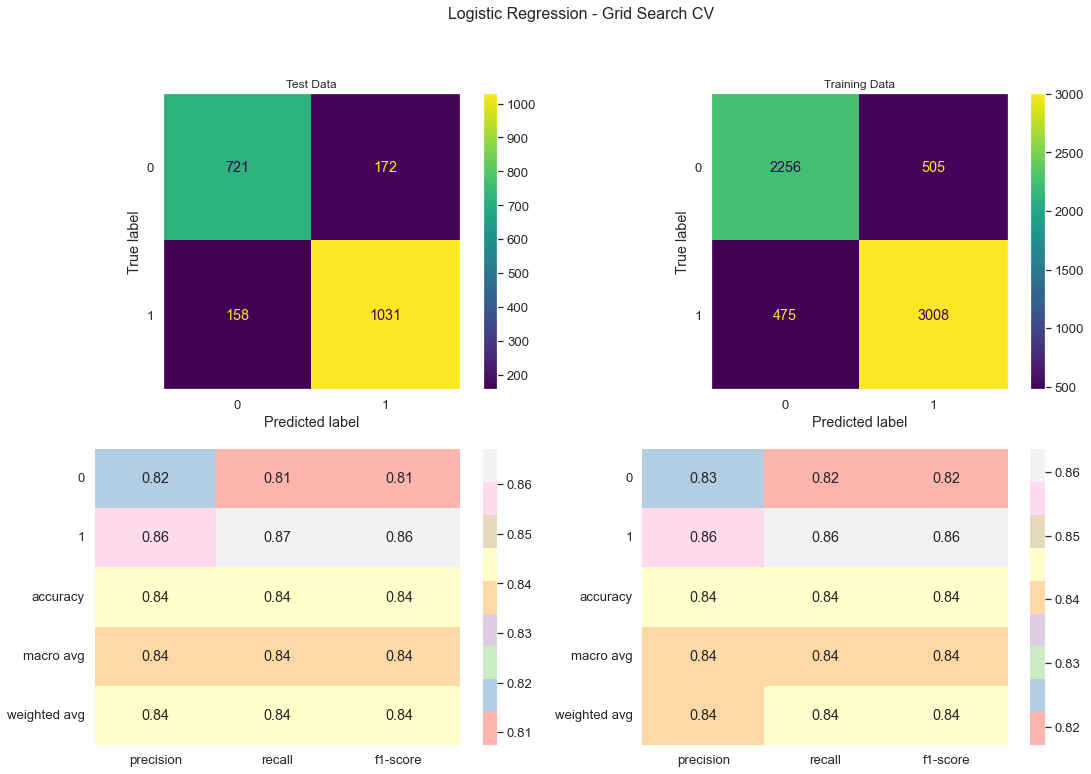

In [463]:
params = {
    'model__penalty': ['l1','l2','elasticnet'],
    'model__solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'model__C': np.linspace(0,1.0,10)
} 

pipeline = Pipeline([('preprocessor',preprocessor),('model',LogisticRegression())])
grid_search_hyperparams("Logistic Regression - Grid Search CV", pipeline, params)

_KNN - (Grid Search CV)_

------------------------------ KNN - Grid Search CV ------------------------------
Train Accuracy Score: 0.85378
Test Accuracy Score: 0.84774
Grid Search Time: 73.25655s
Best Params: {'model__metric': 'manhattan', 'model__n_neighbors': 23, 'model__p': 1, 'model__weights': 'uniform'}


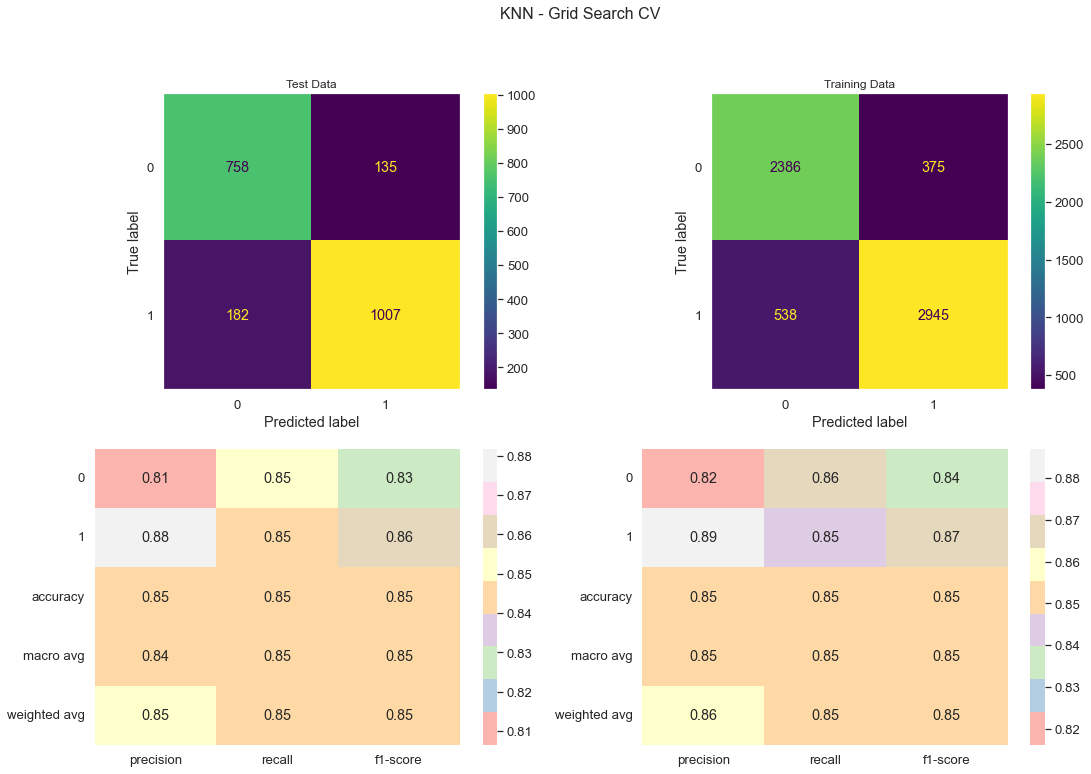

In [464]:
params =  {'model__n_neighbors': np.linspace(1,100,10,dtype = int,),
               'model__weights':['uniform', 'distance'],
               'model__p': [1,2],
               'model__metric': ['euclidean','manhattan']} 

pipeline = Pipeline([('preprocessor',preprocessor),('model',KNeighborsClassifier())])
grid_search_hyperparams("KNN - Grid Search CV", pipeline, params)

_Decision Tree (Grid Search CV)_

------------------------------ Decision Tree - Grid Search CV ------------------------------
Train Accuracy Score: 0.87460
Test Accuracy Score: 0.83622
Grid Search Time: 60.80905s
Best Params: {'model__criterion': 'entropy', 'model__max_depth': 10, 'model__max_features': 'log2', 'model__splitter': 'random'}


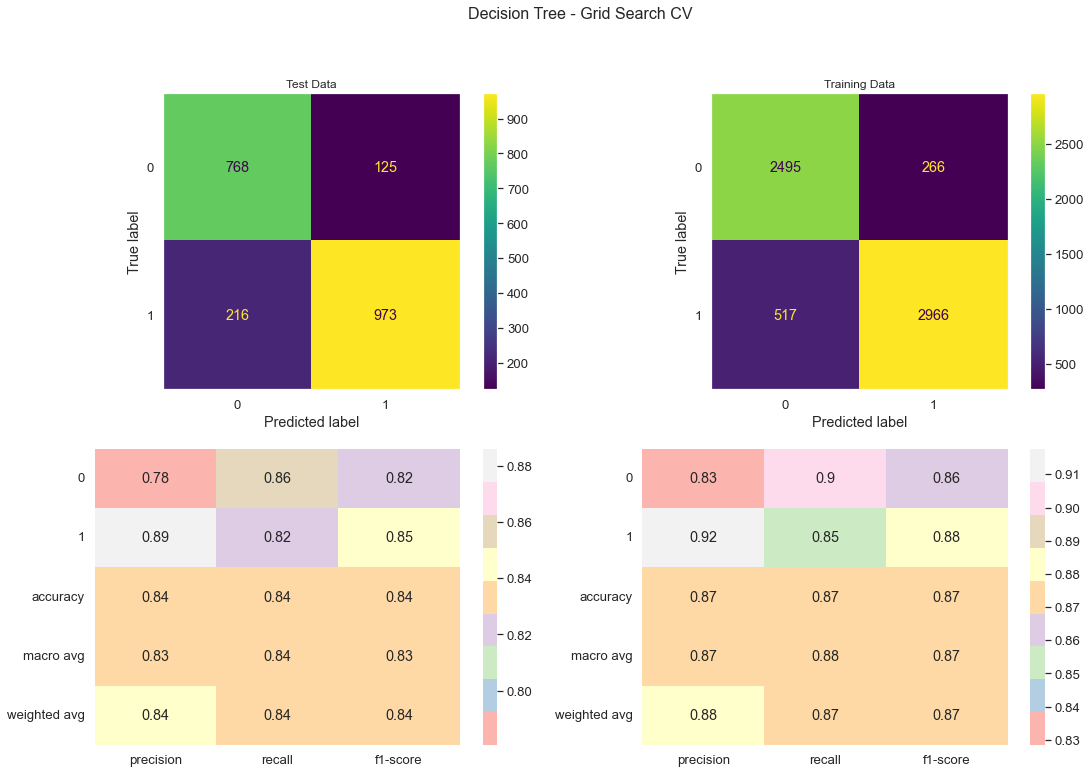

In [465]:
params =  {'model__criterion': ['gini', 'entropy', 'log_loss'],
           'model__max_depth': [None, 10, 12, 14, 16, 18, 20],
           'model__splitter': ['best', 'random'],
           'model__max_features': ['sqrt', 'log2']
          }

pipeline = Pipeline([('preprocessor',preprocessor),('model',DecisionTreeClassifier())])
grid_search_hyperparams("Decision Tree - Grid Search CV", pipeline, params)

_SVM (Grid Search CV)_

------------------------------ SVM - Grid Search CV ------------------------------
Train Accuracy Score: 0.85346
Test Accuracy Score: 0.85062
Grid Search Time: 574.32906s
Best Params: {'model__C': 100, 'model__gamma': 'scale', 'model__kernel': 'rbf'}


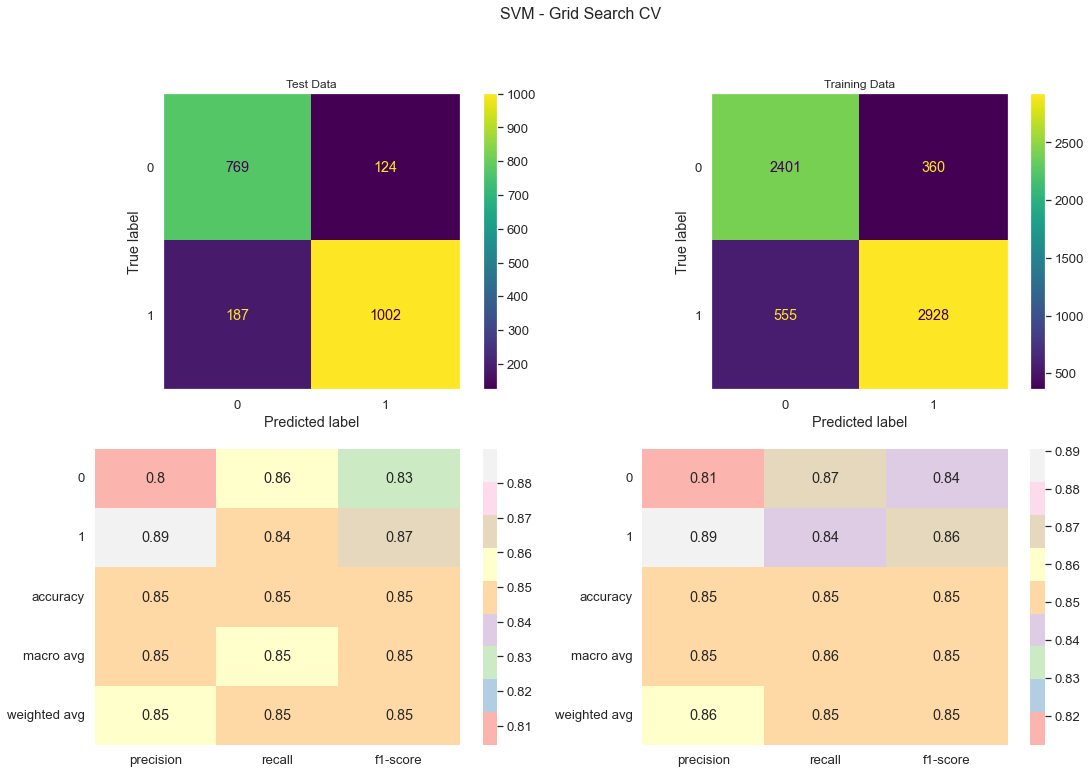

In [466]:
params =  {
           'model__kernel': ['rbf', 'poly', 'linear', 'sigmoid'],
           'model__gamma': ['scale', 'auto'],
           'model__C':[0.1, 1, 10, 100]
          }

pipeline = Pipeline([('preprocessor',preprocessor),('model',SVC())])
grid_search_hyperparams("SVM - Grid Search CV", pipeline, params)

_Random Forest Classifier (Grid Search CV)_

------------------------------ Random Forest Classifier - Grid Search CV ------------------------------
Train Accuracy Score: 0.86803
Test Accuracy Score: 0.85014
Grid Search Time: 471.76057s
Best Params: {'model__criterion': 'entropy', 'model__max_depth': 8, 'model__max_features': 'sqrt', 'model__n_estimators': 200}


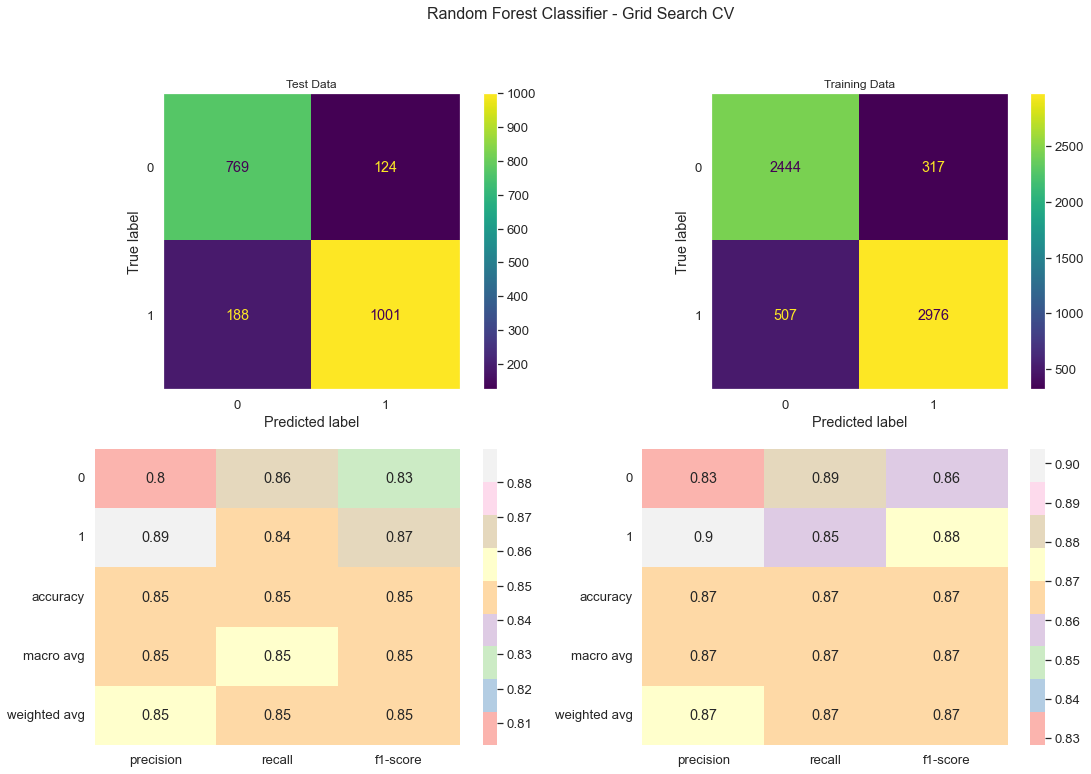

In [468]:
params =  {
           'model__n_estimators': [100, 200, 500],
           'model__max_features': ['auto', 'sqrt', 'log2'],
           'model__max_depth':[ 5, 6, 7, 8, 9, 10],
           'model__criterion' :['gini', 'entropy']
          }    

pipeline = Pipeline([('preprocessor',preprocessor),('model', RandomForestClassifier())])
grid_search_hyperparams("Random Forest Classifier - Grid Search CV", pipeline, params)

In [469]:



df_tuned_results = pd.DataFrame({'Model':['Logistic Regression','KNN','Decision Tree','SVM', 'Random Forest Classifier'],
                                'Train Accuracy':[0.84305,0.85378,0.87460,0.85346,0.86803],
                                'Test Accuracy': [0.84150,0.84774,0.83622,0.85062,0.85014],
                                'Test F1-Score (0)': [0.81,0.83,0.82,0.83,0.83],
                                 'Test F1-Score (1)': [0.86,0.86,0.85,0.87,0.87],
                                'Best Params': [
                                    "{'model__C': 100, 'model__gamma': 'scale', 'model__kernel': 'rbf'}",
                                    "{'model__criterion': 'entropy', 'model__max_depth': 10, 'model__max_features': 'log2', 'model__splitter': 'random'}",
                                    "{'model__metric': 'manhattan', 'model__n_neighbors': 23, 'model__p': 1, 'model__weights': 'uniform'}",
                                    "{'model__C': 0.3333333333333333, 'model__penalty': 'l1', 'model__solver': 'liblinear'}",
                                    "{'model__criterion': 'entropy', 'model__max_depth': 8, 'model__max_features': 'sqrt', 'model__n_estimators': 200}"
                                ]})
df_tuned_results.set_index('Model', inplace=True)
pd.set_option('display.max_colwidth', 500)
                                
df_tuned_results

,Train Accuracy,Test Accuracy,Test F1-Score (0),Test F1-Score (1),Best Params
Model,,,,,
Logistic Regression,0.84305,0.84150,0.81,0.86,"{'model__C': 100, 'model__gamma': 'scale', 'model__kernel': 'rbf'}"
KNN,0.85378,0.84774,0.83,0.86,"{'model__criterion': 'entropy', 'model__max_depth': 10, 'model__max_features': 'log2', 'model__splitter': 'random'}"
Decision Tree,0.87460,0.83622,0.82,0.85,"{'model__metric': 'manhattan', 'model__n_neighbors': 23, 'model__p': 1, 'model__weights': 'uniform'}"
SVM,0.85346,0.85062,0.83,0.87,"{'model__C': 0.3333333333333333, 'model__penalty': 'l1', 'model__solver': 'liblinear'}"
Random Forest Classifier,0.86803,0.85014,0.83,0.87,"{'model__criterion': 'entropy', 'model__max_depth': 8, 'model__max_features': 'sqrt', 'model__n_estimators': 200}"


<hr/>

Based on the above results, the ensemble model **Random Forest Classifer** outperforms every other model. So we will go forward with it.

Train Accuracy Score: 0.86835
Test Accuracy Score: 0.85062
Fit Time: 0.69733s


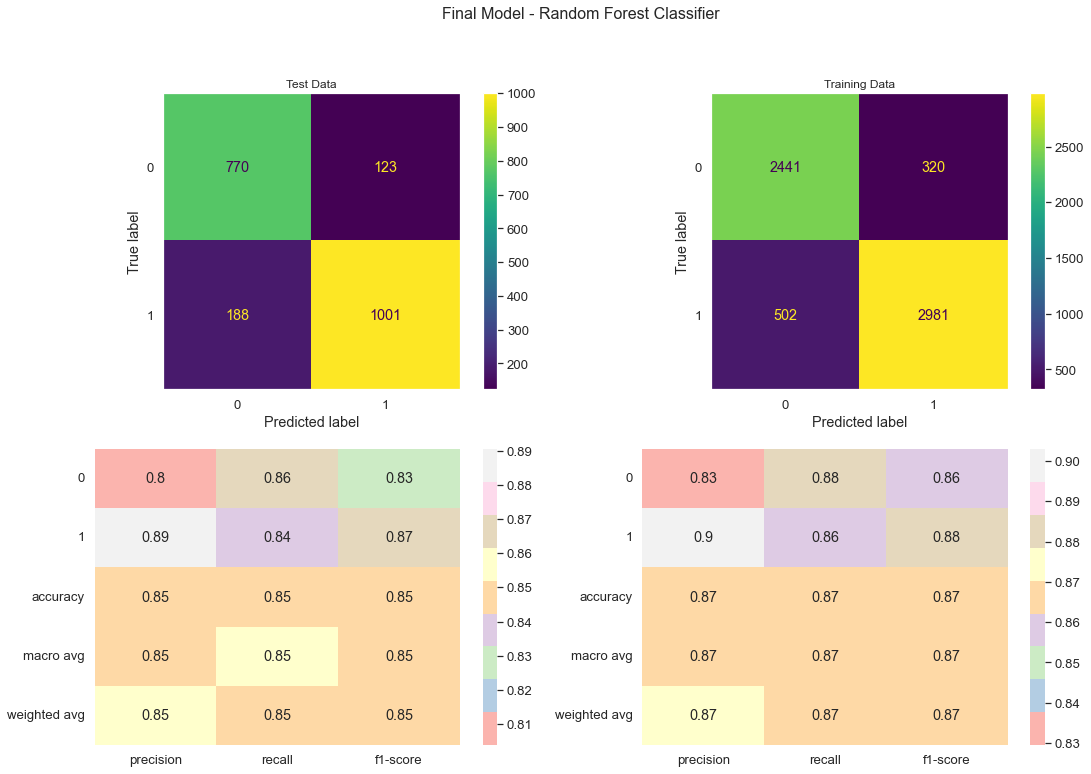

In [471]:
pipeline = Pipeline([('preprocessor',preprocessor),
                     ('model',RandomForestClassifier(criterion='entropy', 
                                                     max_depth=8, 
                                                     max_features='sqrt', 
                                                     n_estimators=200))])
build_and_score_model(pipeline,"Final Model - Random Forest Classifier")

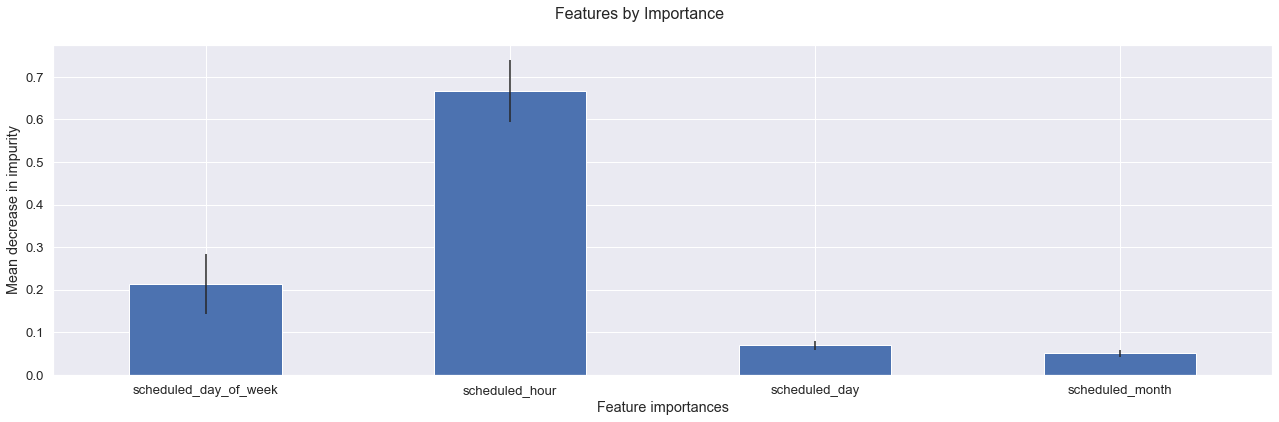

In [744]:
feature_names = list(pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder'].cols)
forest = pipeline.named_steps['model']
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(1, 1,figsize=(18, 6))
fig.suptitle("Features by Importance", size=16)

ax.grid(False)
ax.set(xlabel="Feature importances", ylabel="Mean decrease in impurity")
plot = forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_xticklabels(plot.get_xticklabels(),rotation = 0)
fig.tight_layout()

plt.savefig('images/features.png')


Based on the above observation, **time of the day** and **day of the week** has the most significance in reservations. The appointments don't have much significance for the day of month or does not sway by month.

#### Deployment

Now that we have our model ready, let us do predictions for the next 3 weeks (11/28/2022 - 12/22/2022) to see how the demand is going to be

In [745]:
df_clean.head()

,scheduled_day_of_week,scheduled_hour,scheduled_day,scheduled_month,demand
schedule,,,,,
2018-01-01 10:00:00,Monday,10,01,01,0
2018-01-01 11:00:00,Monday,11,01,01,0
2018-01-01 16:00:00,Monday,16,01,01,0
2018-01-01 18:00:00,Monday,18,01,01,0
2018-01-01 19:00:00,Monday,19,01,01,0


In [746]:
import datetime

df_dec2022 = pd.DataFrame(columns=['schedule','scheduled_day_of_week','scheduled_hour','scheduled_day','scheduled_month','demand'])

for i in range(28,31):
    added_hours = False
    hour = 9
    current = datetime.datetime(2022,11,i,hour,0,0)
    dow = current.strftime('%A')
    if(dow == 'Sunday'):
        hour = 10
        
    while not added_hours:
        current = datetime.datetime(2022,11,i,hour,0,0)
        df_dec2022 = df_dec2022.append({
            'schedule':pd.to_datetime(current),
            'scheduled_day_of_week':dow,
            'scheduled_hour':f'{hour:02d}',
            'scheduled_day':f'{i:02d}',
            'scheduled_month':'12',
            'demand':0},ignore_index=True)
        hour += 1
        if(dow == 'Sunday' and hour >= 19):
            added_hours = True
        elif (hour >= 20):
            added_hours = True


for i in range(1,32):
    added_hours = False
    hour = 9
    current = datetime.datetime(2022,12,i,hour,0,0)
    dow = current.strftime('%A')
    if(dow == 'Sunday'):
        hour = 10
        
    while not added_hours:
        current = datetime.datetime(2022,12,i,hour,0,0)
        df_dec2022 = df_dec2022.append({
            'schedule':pd.to_datetime(current),
            'scheduled_day_of_week':dow,
            'scheduled_hour':f'{hour:02d}',
            'scheduled_day':f'{i:02d}',
            'scheduled_month':'12',
            'demand':0},ignore_index=True)
        hour += 1
        if(dow == 'Sunday' and hour >= 19):
            added_hours = True
        elif (hour >= 20):
            added_hours = True

df_dec2022 = df_dec2022.set_index(['schedule']).sort_index()
df_dec2022.tail()

,scheduled_day_of_week,scheduled_hour,scheduled_day,scheduled_month,demand
schedule,,,,,
2022-12-31 15:00:00,Saturday,15,31,12,0
2022-12-31 16:00:00,Saturday,16,31,12,0
2022-12-31 17:00:00,Saturday,17,31,12,0
2022-12-31 18:00:00,Saturday,18,31,12,0
2022-12-31 19:00:00,Saturday,19,31,12,0


In [747]:
y_dec2022_demand_predictions = pipeline.predict(df_dec2022.drop(columns=['demand']))
y_dec2022_demand_predictions = to_binary(y_dec2022_demand_predictions)

df_dec2022['demand'] = y_dec2022_demand_predictions

In [749]:
import math
import numbers
from datetime import date, timedelta, datetime

def weekly_demand_chart(start,end):
    dow_appointments = df_dec2022[start:end].groupby(['scheduled_hour','scheduled_day_of_week']).sum()['demand'].groupby(level=0).apply(
        lambda x: 100* x/ x.sum()).unstack().loc[:,['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday',
                                                    'Sunday',]]

    dow_appointments = dow_appointments.fillna(0)
    
    def get_label(x,y):
        number = int(y);
        suffix = "AM"
        if(number >= 12):
            if(number > 12):
                number = number - 12
            suffix = "PM"
            
        if dow_appointments[x][y] > 0:
            return f'{str(number)}:00 {suffix}\nBusy'
        else:
            return f'{str(number)}:00 {suffix}\nIdle'

    dow_demand_labels = pd.DataFrame(columns=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday',])

    for i in ['09','10','11','12','13','14','15','16','17','18','19']:
        dow_demand_labels = dow_demand_labels.append({
                    'Monday':get_label('Monday',i),
                    'Tuesday':get_label('Tuesday',i),
                    'Wednesday':get_label('Wednesday',i),
                    'Thursday':get_label('Thursday',i),
                    'Friday':get_label('Friday',i),
                    'Saturday':get_label('Saturday',i),
                    'Sunday':get_label('Sunday',i), 
        },ignore_index=True)
        
    start_date = datetime.strptime(start,'%Y-%m-%d')
    end_date = datetime.strptime(end, '%Y-%m-%d')
    
    xticklabels = []
    while (start_date <= end_date):
        xticklabels.append(f'{start_date.strftime("%A")}-{start_date.strftime("%m/%d")}')
        start_date = start_date + timedelta(days=1)
    
    fig, ax = plt.subplots(1, 1, figsize=(24,10))
    plt.suptitle(f'Demand Predictions for {start} to {end}', size=18,);       
    plot = sns.heatmap(dow_appointments, cmap='YlOrRd', 
                       xticklabels=xticklabels, yticklabels=False,
                       annot=dow_demand_labels, fmt = '',cbar=False,
                       linewidths=0.02, linecolor='gray')
    ax.xaxis.tick_top() # x axis on top
    plot.set(xlabel=None, ylabel=None)
    plt.show()
    fig.tight_layout()

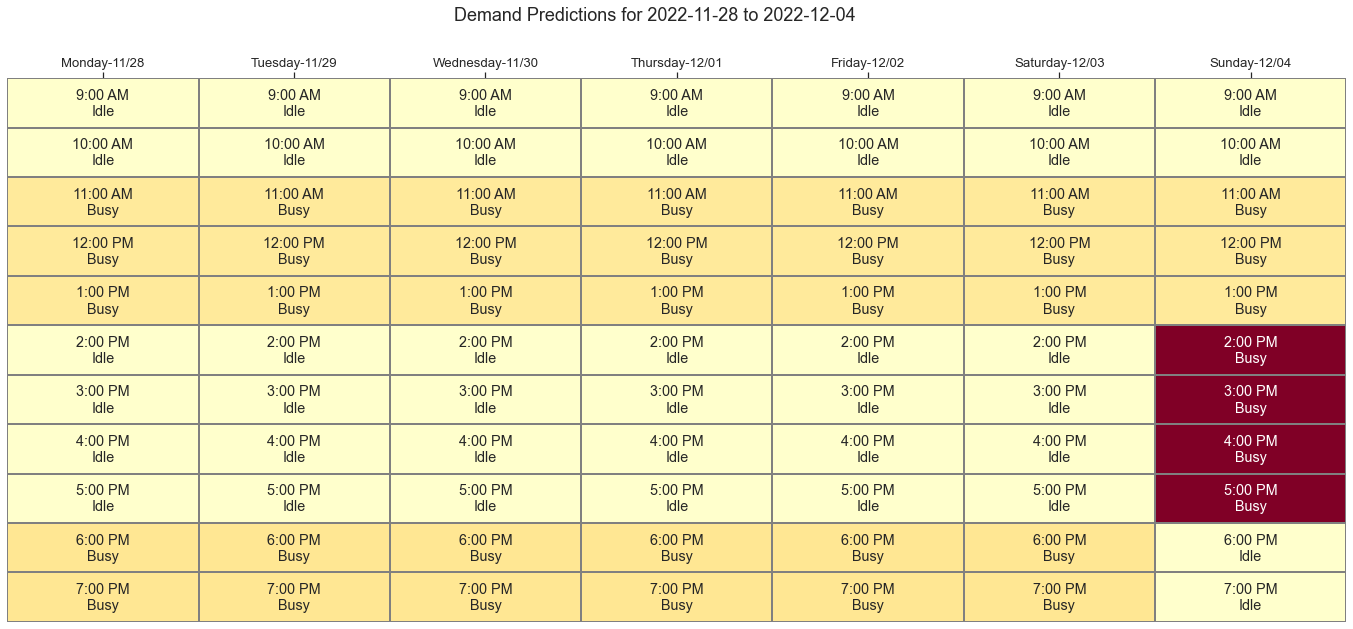

In [750]:
weekly_demand_chart('2022-11-28','2022-12-04')

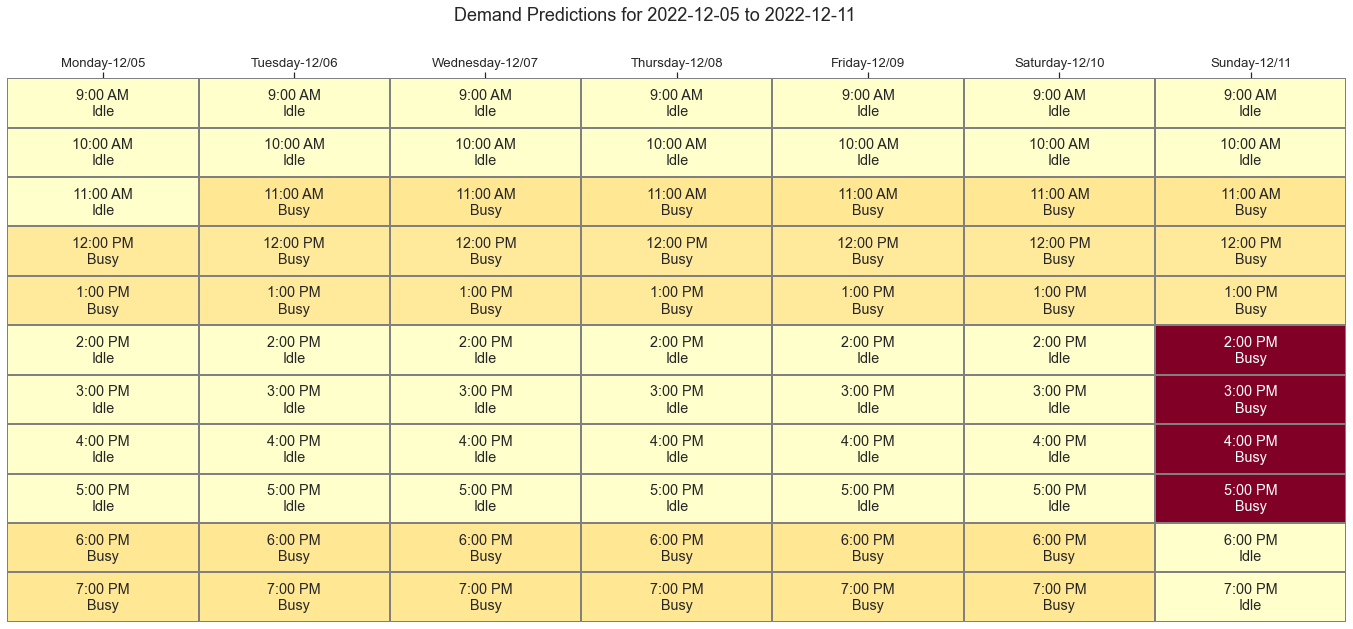

In [751]:
weekly_demand_chart('2022-12-05','2022-12-11')

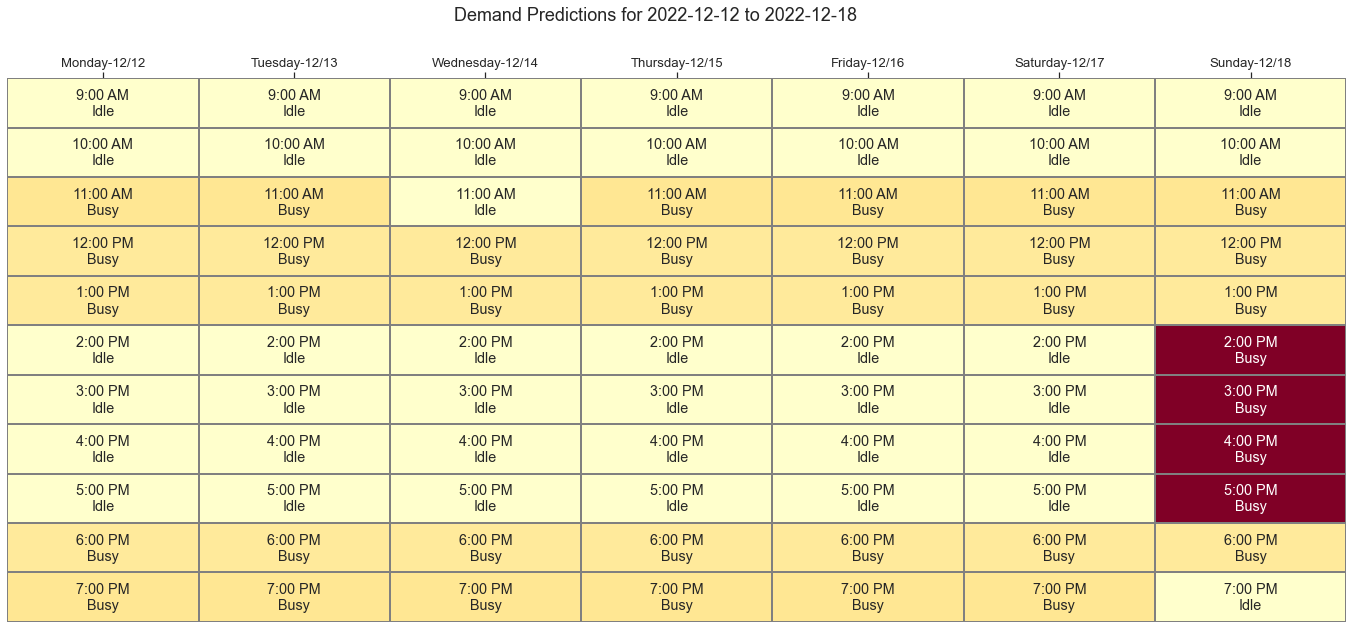

In [752]:
weekly_demand_chart('2022-12-12','2022-12-18')

This way we can continue predicting demand for each week ahead so 'Relax Spa' can resource and provision accordingly